# **Практика 4: Атака DeepFool на модели ИИ**

Выполнил(а) студент **2** курса группы: **ББМО-02-23**

ФИО: **Кузина Анастасия Сергеевна**

 # **Цель задания:**

 Изучить атаку **DeepFool**, которая предназначена для минимальных изменений в изображениях с целью изменения их классификации. Научиться использовать эту атаку и исследовать влияние противоречивых примеров на обученные модели

# **Задачи:**
1. Загрузить ранее обученную модель на датасете **MNIST**;
2. Изучить теоретические основы атаки **DeepFool**;
3. Реализовать атаку **DeepFool** с помощью фреймворка **Foolbox**;
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.

# **Шаги выполнения:**

## **Шаг 1: Загрузка обученной модели и данных MNIST**

 Мы начнем с загрузки уже обученной модели и данных MNIST для их использования в атаке

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# Загрузка тестовых данных MNIST:
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
# Преобразование меток в формат one-hot:
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели:
model = tf.keras.models.load_model('/content/mnist_model.h5')
# Проверка точности модели на обычных данных:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9729 - loss: 0.0920
Test accuracy on clean images: 0.975600004196167


##**Шаг 2: Теория атаки DeepFool**

Атака **DeepFool** — это метод, который был разработан для минимального изменения изображений с целью заставить классификационную модель ошибиться. В отличие от других атак, таких как **FGSM**, **DeepFool** находит минимальные изменения в пространстве признаков, которые достаточны для изменения предсказания модели. Это делает **DeepFool** более эффективной в создании противоречивых примеров с минимальным изменением входных данных

##**Шаг 3: Реализация атаки DeepFool с использованием Foolbox**

 Для выполнения атаки **DeepFool** мы будем использовать библиотеку **Foolbox**, которая поддерживает различные атаки на модели ИИ, включая **DeepFool**.

In [4]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.4 MB/s eta 0:00:00


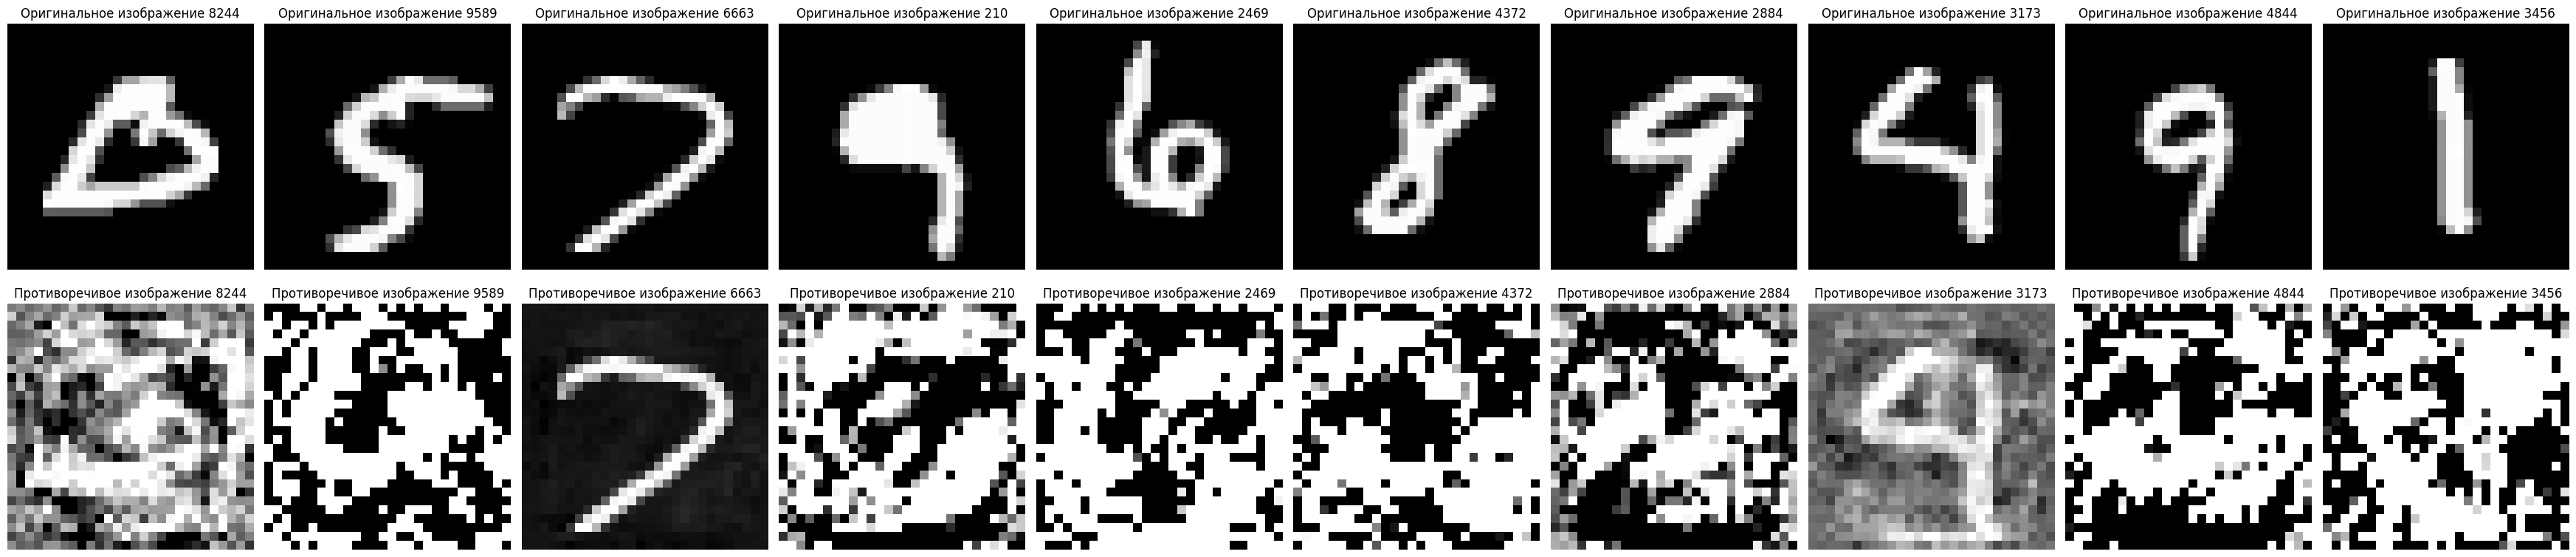

In [19]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели:
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

# Создание атаки DeepFool:
attack = fb.attacks.L2DeepFoolAttack(steps=100)

# Количество изображений для атаки:
num_images = 10

# Случайный выбор индексов изображений:
random_indices = np.random.choice(len(test_images), num_images, replace=False)

# Создание подграфиков для отображения результатов:
plt.figure(figsize=(35, 8))

for i in range(num_images):

    # Выбор случайного изображения для атаки:
    index = random_indices[i]

    # Выбор изображения для атаки:
    image = tf.convert_to_tensor(test_images[index], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[index])
    label = tf.convert_to_tensor(label, dtype=tf.int64)

    # Выполнение атаки:
    adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.01)

    # Отображение оригинального изображения:
    plt.subplot(2, num_images, i + 1)
    plt.title(f"Оригинальное изображение {index+1}")
    plt.imshow(image[0].numpy(), cmap="gray")
    plt.axis('off')

    # Отображение противоречивого изображения:
    plt.subplot(2, num_images, num_images + i + 1)
    plt.title(f"Противоречивое изображение {index+1}")
    plt.imshow(adversarial_image[0].numpy(), cmap="gray")
    plt.axis('off')

plt.tight_layout()
plt.show()

##**Шаг 4: Оценка модели на противоречивых примерах**

 Теперь мы проверим, насколько сильно атака **DeepFool** влияет на точность модели. Мы создадим набор противоречивых примеров и оценим производительность модели на этих данных.

In [25]:
import tensorflow as tf
import numpy as np

# Установка количества изображений:
num_samples = 100

# Случайный выбор индексов изображений:
random_indices = np.random.choice(len(test_images), num_samples, replace=False)

# Инициализация списка для хранения противоречивых изображений:
adversarial_images = []

# Генерация противоречивых изображений для выбранных индексов:
for i in random_indices:
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)

    try:
        advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
        adversarial_images.append(advs)
        print(f"Изображение {i + 1}: Атака успешна: {success}")

    except Exception as e:
        print(f"Ошибка при выполнении атаки на изображении {i + 1}: {e}")

# Объединение всех противоречивых изображений в один тензор:
adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка модели на противоречивых примерах:
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[random_indices])
print(f'Accuracy on adversarial examples (DeepFool): {adversarial_acc}')

Изображение 1192: Атака успешна: [False]
Изображение 3784: Атака успешна: [False]
Изображение 9964: Атака успешна: [False]
Изображение 7870: Атака успешна: [False]
Изображение 4415: Атака успешна: [False]
Изображение 802: Атака успешна: [False]
Изображение 2683: Атака успешна: [False]
Изображение 9469: Атака успешна: [False]
Изображение 3053: Атака успешна: [False]
Изображение 1921: Атака успешна: [False]
Изображение 7097: Атака успешна: [False]
Изображение 3298: Атака успешна: [False]
Изображение 7958: Атака успешна: [False]
Изображение 8434: Атака успешна: [False]
Изображение 3590: Атака успешна: [False]
Изображение 3495: Атака успешна: [False]
Изображение 300: Атака успешна: [False]
Изображение 3589: Атака успешна: [False]
Изображение 7724: Атака успешна: [False]
Изображение 3926: Атака успешна: [False]
Изображение 6517: Атака успешна: [False]
Изображение 4660: Атака успешна: [False]
Изображение 8686: Атака успешна: [False]
Изображение 6379: Атака успешна: [False]
Изображение 8481: 

##**Шаг 5: Сравнение результатов**

Снижение точности модели до 0% на примерах, подвергнутых атакам, подчеркивает серьезные уязвимости в системах машинного обучения. Это явление часто связано с высокой чувствительностью моделей к небольшим, но тщательно подобранным изменениям в входных данных, как в случае с атакой **DeepFool**.

Данная атака демонстрирует, как даже незначительные модификации могут сбивать с толку модели, что вызывает серьезные опасения относительно их надежности в реальных приложениях.

**Проблемы и риски:**
1. **Уязвимость к атакам:** Модели, которые демонстрируют такую низкую точность на атакованных примерах, могут быть легко обмануты злоумышленниками. Это особенно критично в областях, таких как безопасность и автономные транспортные средства, где точность распознавания объектов и дорожных знаков имеет решающее значение;
2. **Потеря доверия:** Снижение точности может подорвать доверие пользователей к системам машинного обучения. Если модели не могут надежно обрабатывать даже незначительные изменения во входных данных, это вызывает сомнения в их применимости и безопасности.

**Заключение:**

Снижение точности на атакованных примерах подчеркивает необходимость учитывать устойчивость моделей к внешним воздействиям. Это особенно важно для применения в реальных условиях, где системы могут подвергаться различным манипуляциям. Разработка эффективных методов защиты становится критически важной для обеспечения надежности и доверия к моделям машинного обучения в потенциально враждебных условиях.